# Visually compare two graphs

In [24]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
print('nx:', nx.__version__)
print('pd:', pd.__version__)

nx: 2.4
pd: 1.0.1


# Data

First graph

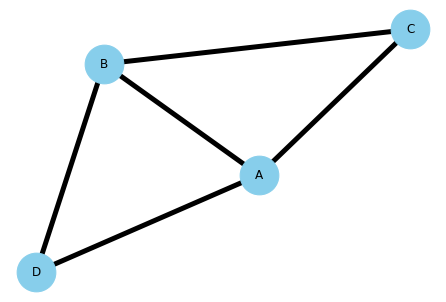

In [52]:
df1 = pd.DataFrame(
[ [0, 2, 2, 2],
  [0, 0, 1, 1],
  [0, 0, 1, 0],
  [0, 0, 0, 0]], index=['A','B','C','D'], columns=['A','B','C','D']
)

G1 = nx.from_pandas_adjacency(df1)
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1500, width=5.0, edge_cmap=plt.cm.Set2) 

Second graph.
Node `C` is removed, two new nodes `E` and `F` added.

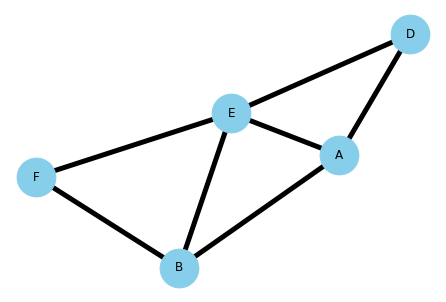

In [37]:
df2 = pd.DataFrame(
[ [0, 1, 2, 3, 0],
  [0, 0, 0, 1, 1],
  [0, 0, 1, 1, 0],
  [0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0]], index=['A','B','D','E','F'], columns=['A','B','D', 'E','F']
)

G2 = nx.from_pandas_adjacency(df2)
nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, width=5.0, edge_cmap=plt.cm.Set2)

# Compare

Figure out nodes changes:

In [38]:
index1 = df1.index
index2 = df2.index
same = index1.intersection(index2)
removed = index1.difference(index2)
added = index2.difference(index1)
print('added nodes', list(added))
print('removed nodes', list(removed))
print('same nodes', list(same))

added nodes ['E', 'F']
removed nodes ['C']
same nodes ['A', 'B', 'D']


In [39]:
nodes_state = {n:0 for n in same}
for n in removed:
    nodes_state[n] = -1
for n in added:
    nodes_state[n] = 1
nodes_state = pd.DataFrame(nodes_state.items(), columns=['Node', 'State']).sort_values('Node')
nodes_state

,Node,State
0,A,0
1,B,0
3,C,-1
2,D,0
4,E,1
5,F,1


Figure out edges changes (in the unaffected nodes)

In [40]:
df_compare = (df1.loc[same, same] == df2.loc[same, same]).astype(int)
df_compare[(df2.loc[same, same]==0)&(df1.loc[same, same]!=0)] = -2
df_compare[(df2.loc[same, same]!=0)&(df1.loc[same, same]==0)] = 2

In [41]:
df_compare

,A,B,D
A,1,0,1
B,1,1,-2
D,1,1,2


Add info about added/removed nodes

In [42]:
df_compare = df_compare.reindex(index = df_compare.index.union(removed), columns=df_compare.index.union(removed))
df_compare = df_compare.fillna(-2)
df_compare = df_compare.reindex(index = df_compare.index.union(added), columns=df_compare.index.union(added))
df_compare = df_compare.fillna(+2).astype(int)
display(df1, df2)
print('Comparison result:')
print("""
#  1 = same edge
#  0 = changed edge
# -2 = removed node
# +2 = added node""")

display(df_compare)

,A,B,C,D
A,0,2,2,2
B,0,0,1,1
C,0,0,1,0
D,0,0,0,0


,A,B,D,E,F
A,0,1,2,3,0
B,0,0,0,1,1
D,0,0,1,1,0
E,0,0,0,0,1
F,0,0,0,0,0


Comparison result:

#  1 = same edge
#  0 = changed edge
# -2 = removed node
# +2 = added node


,A,B,C,D,E,F
A,1,0,-2,1,2,2
B,1,1,-2,-2,2,2
C,-2,-2,-2,-2,2,2
D,1,1,-2,2,2,2
E,2,2,2,2,2,2
F,2,2,2,2,2,2


# Merge

Now, merge two graphs into one large graph. We'll show all nodes and edges indicating state with color.

In [43]:
df_view1 = df1.reindex(index=df_compare.index, columns=df_compare.index).fillna(0)
df_view2 = df2.reindex(index=df_compare.index, columns=df_compare.index).fillna(0)

df_view = pd.DataFrame(
    np.max(np.stack((df_view1.values, df_view2.values)), axis=0),
    index=df_compare.index, columns=df_compare.index)
df_view

,A,B,C,D,E,F
A,0.0,2.0,2.0,2.0,3.0,0.0
B,0.0,0.0,1.0,1.0,1.0,1.0
C,0.0,0.0,1.0,0.0,0.0,0.0
D,0.0,0.0,0.0,1.0,1.0,0.0
E,0.0,0.0,0.0,0.0,0.0,1.0
F,0.0,0.0,0.0,0.0,0.0,0.0


# Visualize

Now, drawing time.

Let's remember two input graphs:

In [44]:
G=nx.from_pandas_adjacency(df_view)

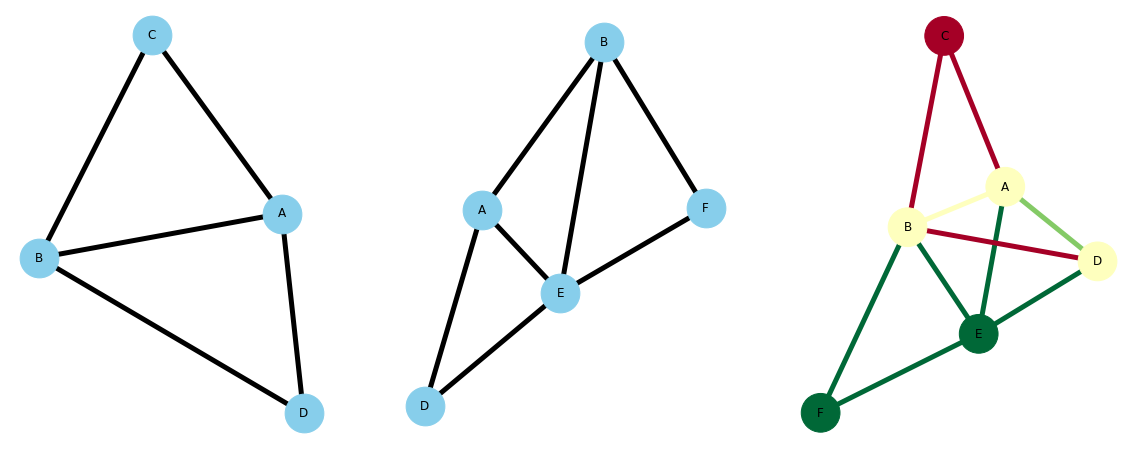

In [45]:
fig, ax = plt.subplots(1,3, figsize=(20,8))
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1500, width=5.0, edge_cmap=plt.cm.Set2, ax=ax[0])
nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, width=5.0, edge_cmap=plt.cm.Set2, ax=ax[1])
nx.draw(G, with_labels=True,
        node_color=nodes_state['State'],
        node_size=1500, width=5.0,
        edge_color=[df_compare.loc[e] for e in G.edges],
        edge_cmap=plt.cm.RdYlGn,
        cmap='RdYlGn', ax=ax[2])

Nodes legend:
 
 - green:  new            (added nodes `E` and `F`)
 - red:    removed        (removed `C`)
 - yellow: unaffected     (`A`, `B`, `D`)
 

Edges:

 - red: removed (All `C` edges, (`D`-`B`) edge
 - dark green: added edges. 
 - light green: unaffected edged (`A`-`D`)
 - yellow: existing edges who chnaged their value (`A`-`B`)
 

